In [51]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import seaborn as sns
from nltk.util import bigrams
%matplotlib inline
sns.set()

In [46]:
# Set errorbar style
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
font = {'family' : 'normal',
        'size'   : 15}

In [53]:
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

bin_labels = ['{} - {}'.format(b1, b2) for b1, b2 in bigrams(price_bins)]

In [3]:
with open('incent_results.json') as f:
    incent = json.load(f)
    
with open('non_incent_results.json') as f:
    non_incent = json.load(f)
    
with open('whole_dataset_results.json') as f:
    whole_dataset = json.load(f)

In [4]:
def reshape_samples(samples):
    return { k: [sample[k] for sample in samples] for k in samples[0].keys()}

In [5]:
incent = reshape_samples(incent)
non_incent = reshape_samples(non_incent)
whole_dataset = reshape_samples(whole_dataset)

In [6]:
categories = [c['main_category'] for c in incent['avg_length_by_category'][0]]
price_tiers = [c['price_tier'] for c in incent['num_reviews_by_price_tier'][0]]

In [7]:
def reshape_grouped_by_category(data):
    return {c: [group['_c1'] for sample in data for group in sample if group['main_category'] == c] for c in categories}

In [8]:
incent_by_category = {k: reshape_grouped_by_category(v) for k, v in incent.items() if k.endswith('by_category')}
non_incent_by_category = {k: reshape_grouped_by_category(v) for k, v in non_incent.items() if k.endswith('by_category')}
whole_dataset_by_category = {k: reshape_grouped_by_category(v) for k, v in whole_dataset.items() if k.endswith('by_category')}

In [9]:
def reshape_grouped_by_price_tier(data):
    return {t: [group['_c1'] for sample in data for group in sample if group['price_tier'] == t] for t in price_tiers}

In [10]:
incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in incent.items() if k.endswith('by_price_tier')}
non_incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in non_incent.items() if k.endswith('by_price_tier')}
whole_dataset_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in whole_dataset.items() if k.endswith('by_price_tier')}

In [11]:
def reshape_grouped_by_overall(data):
    return {o: [group['_c1'] for sample in data for group in sample if group['overall'] == o] for o in range(1, 6)}

In [12]:
incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
non_incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in non_incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
whole_dataset_by_overall = {k: reshape_grouped_by_overall(v) for k, v in whole_dataset.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}

In [13]:
def confidence_interval(estimates, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def dict_barplot(data, errs, ax=None):
    if ax is None:
        ax = plt.subplot()
    data.plot(kind='bar', ax=ax, yerr=errs, fontsize = 14)

def plot_with_conf_interval(data_incent, data_non_incent, confidence=0.95, ax=None, sort_value=False):
    conf_incent = {k: confidence_interval(v, confidence) for k, v in data_incent.items()}
    means_incent = {k: v[0] for k, v in conf_incent.items()}
    errs_incent = {k: v[2] - v[1] for k, v in conf_incent.items()}
    
    conf_non_incent = {k: confidence_interval(v, confidence) for k, v in data_non_incent.items()}
    means_non_incent = {k: v[0] for k, v in conf_non_incent.items()}
    errs_non_incent = {k: v[2] - v[1] for k, v in conf_non_incent.items()}
    
    df_value = pd.DataFrame({'Incentivized': means_incent, 'Non incentivized': means_non_incent})
    df_error = pd.DataFrame({'Incentivized': errs_incent, 'Non incentivized': errs_non_incent})
    
    if sort_value:
        df_value.sort_values(by='Incentivized', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


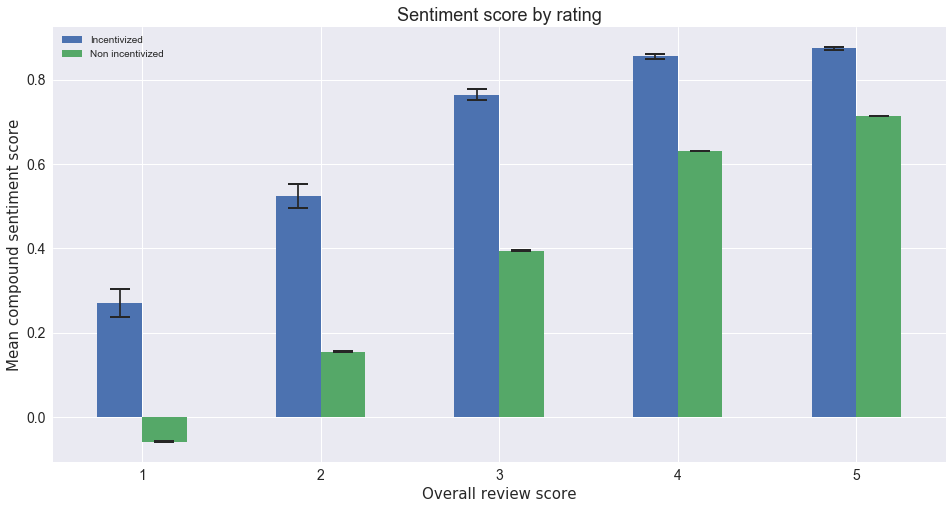

In [45]:
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax1 = plt.subplots(figsize=(16, 8))
plot_with_conf_interval(incent_by_overall['avg_compound_by_rating'], non_incent_by_overall['avg_compound_by_rating'], ax=ax1)

ax1.set_xlabel('Overall review score', font)
ax1.set_ylabel('Mean compound sentiment score', font)
plt.xticks(rotation=0)
plt.title('Sentiment score by rating', fontsize=18)

fig.savefig('sentiment_by_rating.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


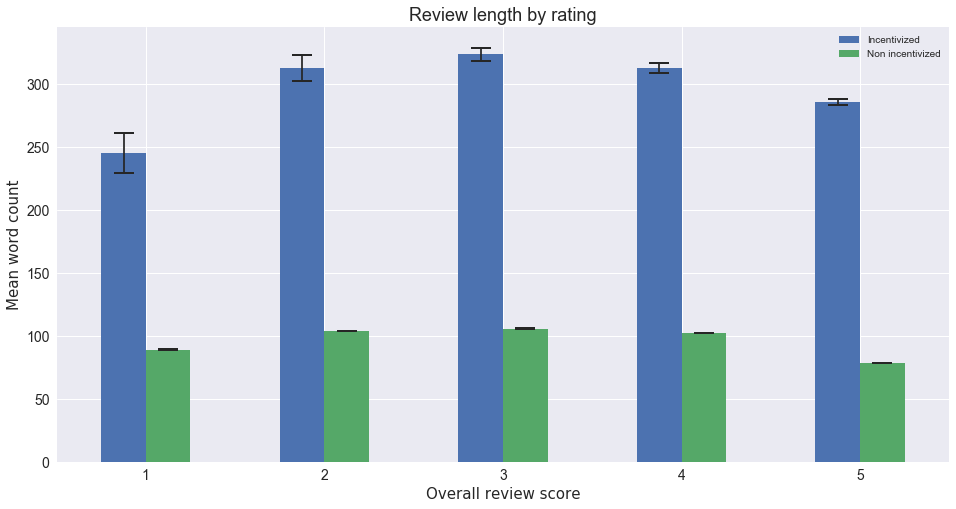

In [44]:
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax1 = plt.subplots(figsize=(16, 8))
plot_with_conf_interval(incent_by_overall['avg_length_by_overall'], non_incent_by_overall['avg_length_by_overall'], ax=ax1)

ax1.set_xlabel('Overall review score', font)
ax1.set_ylabel('Mean word count', font)
plt.xticks(rotation=0)
plt.title('Review length by rating', fontsize=18)

fig.savefig('wordcount_by_rating.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


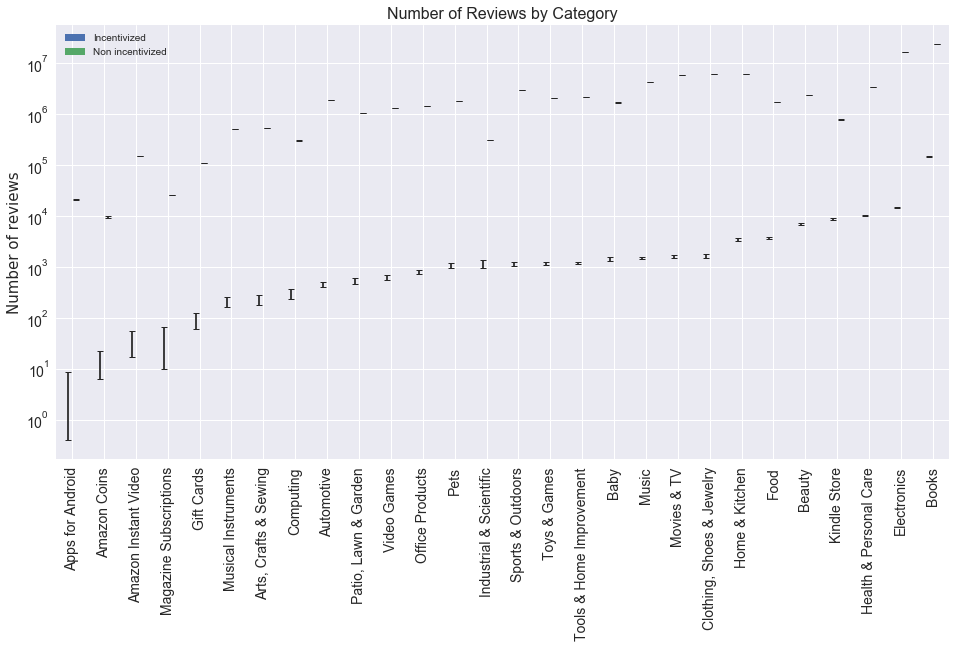

In [32]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval(incent_by_category[title], non_incent_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Number of reviews', font)
plt.xticks(rotation=90)
ax.set_yscale('log')
plt.title('Number of Reviews by Category', fontsize=16)

fig.savefig(title+'.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


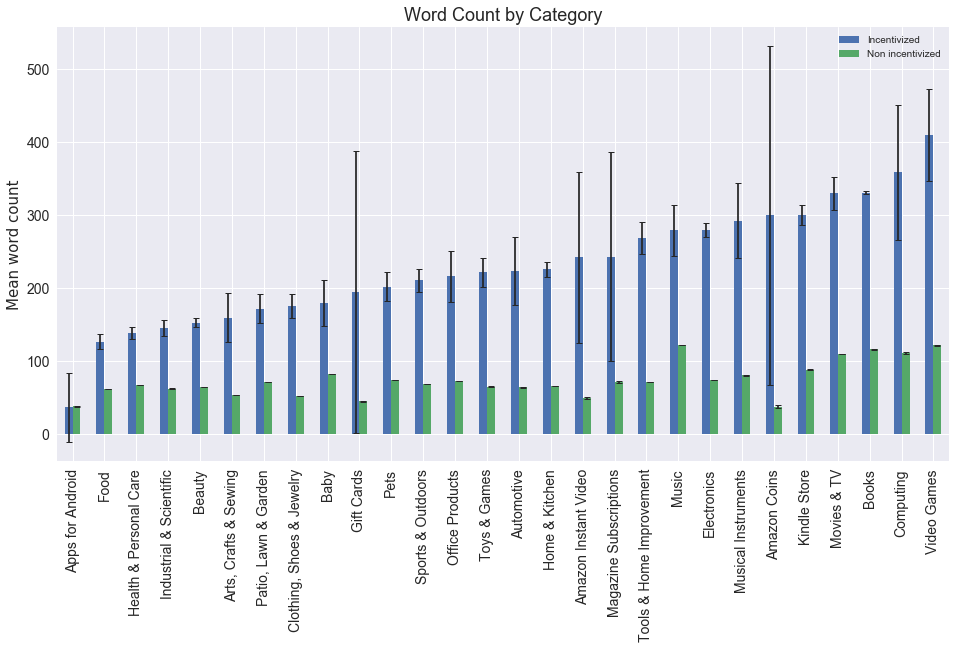

In [43]:
title = 'avg_length_by_category'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval(incent_by_category[title], non_incent_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Mean word count', font)
plt.xticks(rotation=90)
plt.title('Word Count by Category', fontsize=18)

fig.savefig(title + '.png', bbox_inches='tight')

In [25]:
def plot_with_conf_interval_single(data, confidence=0.95, ax=None, sort_value=False):
    conf = {k: confidence_interval(v, confidence) for k, v in data.items()}
    means = {k: v[0] for k, v in conf.items()}
    errs = {k: v[2] - v[1] for k, v in conf.items()}
    
    df_value = pd.DataFrame({'Whole dataset': means})
    df_error = pd.DataFrame({'Whole dataset': errs})
    
    if sort_value:
        df_value.sort_values(by='Whole dataset', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


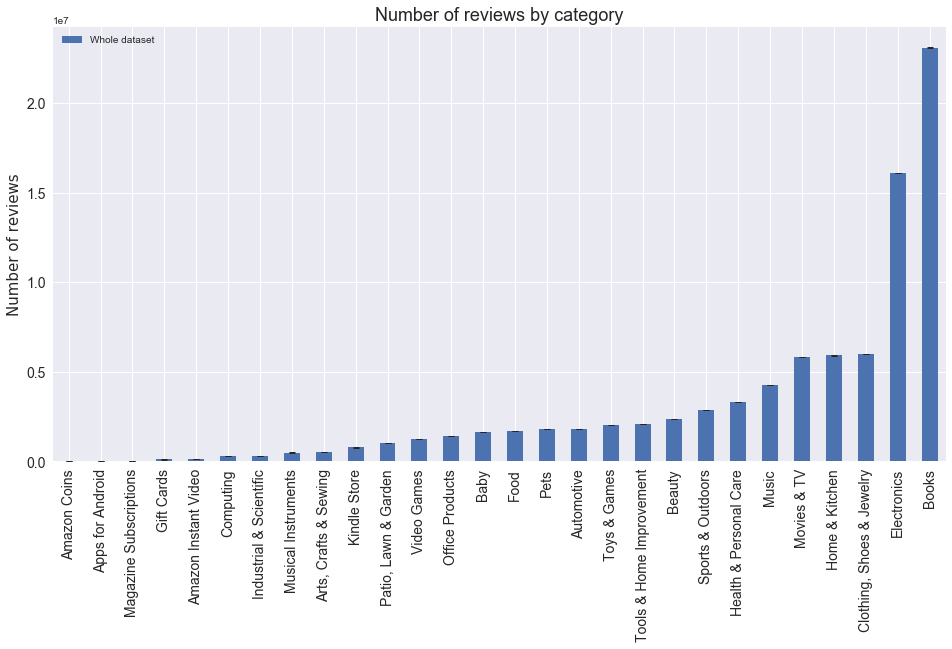

In [34]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval_single(whole_dataset_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Number of reviews', font)
plt.xticks(rotation=90)
plt.title('Number of reviews by category', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


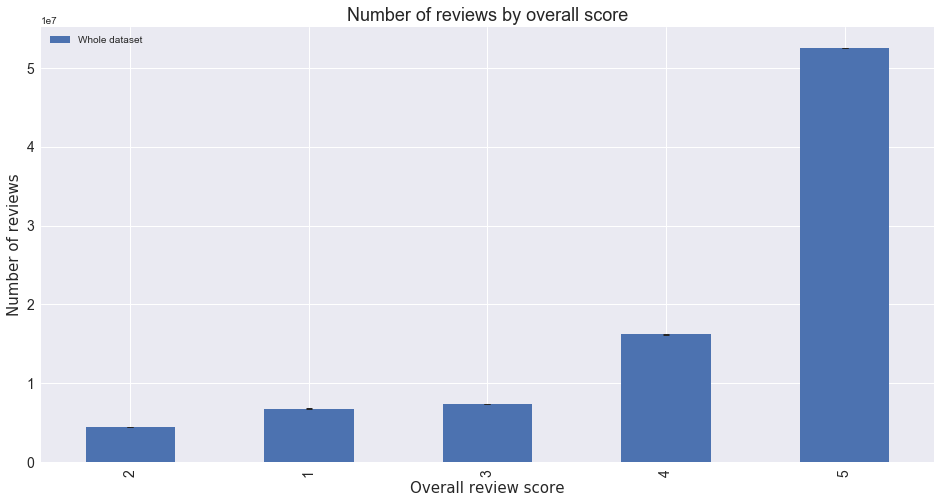

In [64]:
title = 'num_reviews_by_overall'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax, sort_value=True)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Number of reviews', font)
plt.xticks(rotation=90)
plt.title('Number of reviews by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


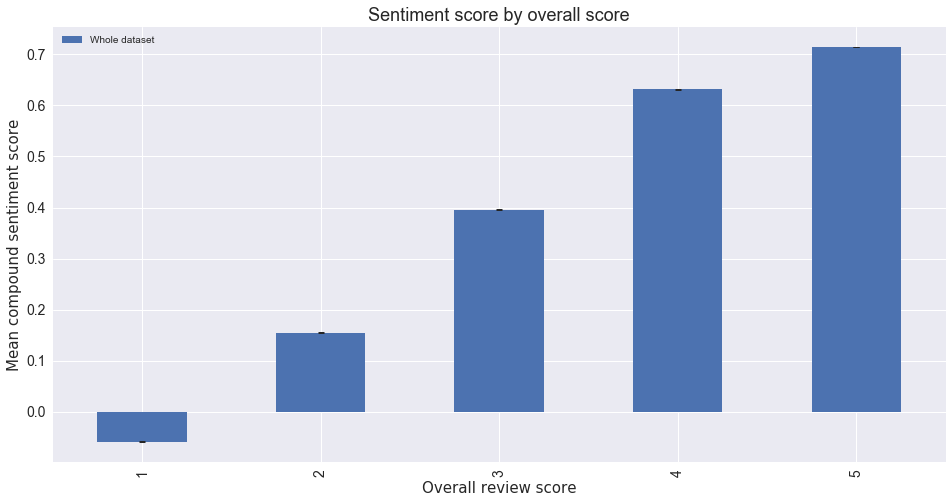

In [65]:
title = 'avg_compound_by_overall'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax, sort_value=True)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean compound sentiment score', font)
plt.xticks(rotation=90)
plt.title('Sentiment score by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


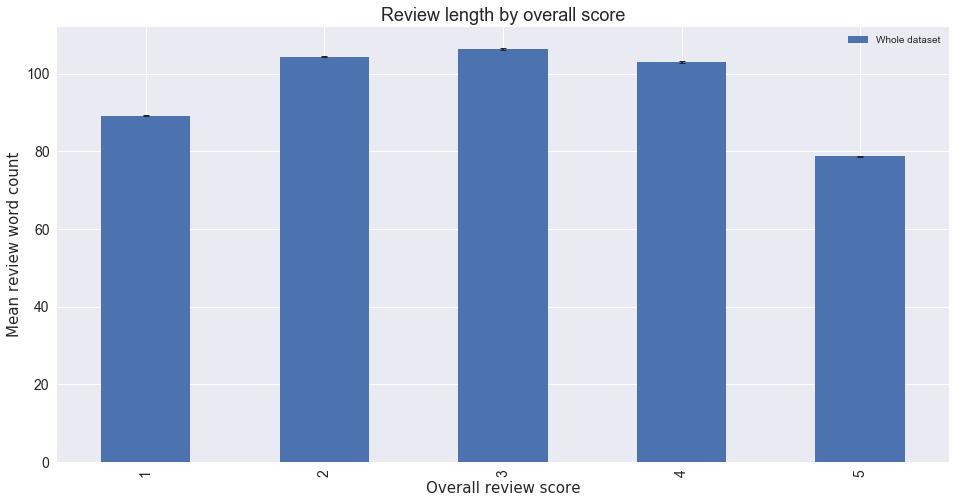

In [66]:
title = 'avg_length_by_overall'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)#, sort_value=True)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean review word count', font)
plt.xticks(rotation=90)
plt.title('Review length by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\Users\nspace\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


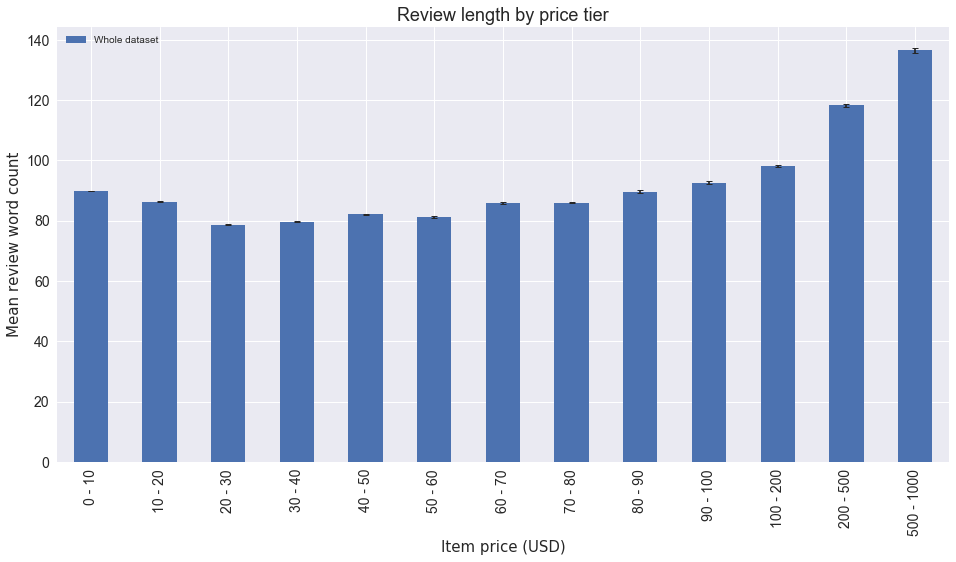

In [57]:
title = 'avg_length_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=(16, 8))
plot_with_conf_interval_single(whole_dataset_by_price_tier[title], ax=ax)#, sort_value=True)

ax.set_xlabel('Item price (USD)', font)
ax.set_ylabel('Mean review word count', font)
ax.set_xticklabels(bin_labels)
plt.xticks(rotation=90)
plt.title('Review length by price tier', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')